## Import libraries ##

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import keras
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.metrics import RootMeanSquaredError
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
import warnings

warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)
from xgboost import XGBRegressor

## Load data ##


In [2]:
def get_data():
    train = pd.read_csv('internship_train.csv')
    test = pd.read_csv('internship_hidden_test.csv')
    return train, test


def get_combined_data():
    # reading train data
    train, test = get_data()

    target = train.target
    train.drop(['target'], axis=1, inplace=True)

    combined = train.append(test)
    combined.reset_index(inplace=True)
    combined.drop(['index'], inplace=True, axis=1)
    return combined, target

In [3]:
# Load train and test data into pandas DataFrames
train_data, test_data = get_data()

In [4]:
# Combine train and test data to process them together
combined, target = get_combined_data()
combined.describe()

,0,1,2,3,4,5,6,7,8,9,...,43,44,45,46,47,48,49,50,51,52
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.00000,100000.000000,...,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,249.320290,250.231820,248.580050,249.762160,249.656780,249.658410,-0.018188,0.499214,0.49849,249.440190,...,7.503887,7.476497,7.524251,7.502529,7.469883,7.497906,7.478122,7.504823,7.488781,7.512350
std,144.314835,144.104507,144.175567,144.257312,144.022951,144.363334,7.037576,0.288389,0.50000,144.441941,...,4.330524,4.329526,4.323416,4.331486,4.333019,4.333708,4.326096,4.330061,4.326173,4.328913
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-9.949874,0.000014,0.00000,0.000000,...,0.000060,0.000019,0.000040,0.000154,0.000026,0.000367,0.000014,0.000160,0.000147,0.000125
25%,124.000000,126.000000,124.000000,125.000000,125.000000,124.000000,-7.071068,0.250152,0.00000,124.000000,...,3.763833,3.712038,3.793671,3.757038,3.720887,3.745841,3.717338,3.766102,3.744631,3.780920
50%,250.000000,251.000000,248.000000,250.000000,250.000000,250.000000,0.000000,0.498193,0.00000,250.000000,...,7.491644,7.479817,7.535052,7.487508,7.451395,7.507089,7.485669,7.504376,7.478592,7.499734
75%,374.000000,375.000000,374.000000,374.000000,374.000000,374.000000,7.071068,0.747864,1.00000,375.000000,...,11.259476,11.214688,11.278405,11.256728,11.211880,11.246148,11.217283,11.270899,11.238515,11.271359
max,499.000000,499.000000,499.000000,499.000000,499.000000,499.000000,9.949874,0.999987,1.00000,499.000000,...,14.999605,14.999900,14.999954,14.999733,14.999478,14.999869,14.999928,14.999992,14.999364,14.999775


In [5]:
combined.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 53 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   0       100000 non-null  int64  
 1   1       100000 non-null  int64  
 2   2       100000 non-null  int64  
 3   3       100000 non-null  int64  
 4   4       100000 non-null  int64  
 5   5       100000 non-null  int64  
 6   6       100000 non-null  float64
 7   7       100000 non-null  float64
 8   8       100000 non-null  int64  
 9   9       100000 non-null  int64  
 10  10      100000 non-null  int64  
 11  11      100000 non-null  int64  
 12  12      100000 non-null  int64  
 13  13      100000 non-null  float64
 14  14      100000 non-null  float64
 15  15      100000 non-null  float64
 16  16      100000 non-null  float64
 17  17      100000 non-null  float64
 18  18      100000 non-null  float64
 19  19      100000 non-null  float64
 20  20      100000 non-null  float64
 21  21      100

## Data analysis ##

In [6]:
def get_cols_with_no_nans(df, col_type):
    '''
    Arguments :
    df : The dataframe to process
    col_type :
          num : to only get numerical columns with no nans
          no_num : to only get nun-numerical columns with no nans
          all : to get any columns with no nans
    '''
    if (col_type == 'num'):
        predictors = df.select_dtypes(exclude=['object'])
    elif (col_type == 'no_num'):
        predictors = df.select_dtypes(include=['object'])
    elif (col_type == 'all'):
        predictors = df
    else:
        print('Error : choose a type (num, no_num, all)')
        return 0
    cols_with_no_nans = []
    for col in predictors.columns:
        if not df[col].isnull().any():
            cols_with_no_nans.append(col)
    return cols_with_no_nans



In [7]:
num_cols = get_cols_with_no_nans(combined, 'num')
cat_cols = get_cols_with_no_nans(combined, 'no_num')

print('Number of numerical columns with no nan values :', len(num_cols))
print('Number of nun-numerical columns with no nan values :', len(cat_cols))

Number of numerical columns with no nan values : 53
Number of nun-numerical columns with no nan values : 0


array([[<AxesSubplot:title={'center':'0'}>,
        <AxesSubplot:title={'center':'1'}>,
        <AxesSubplot:title={'center':'2'}>,
        <AxesSubplot:title={'center':'3'}>,
        <AxesSubplot:title={'center':'4'}>,
        <AxesSubplot:title={'center':'5'}>,
        <AxesSubplot:title={'center':'6'}>],
       [<AxesSubplot:title={'center':'7'}>,
        <AxesSubplot:title={'center':'8'}>,
        <AxesSubplot:title={'center':'9'}>,
        <AxesSubplot:title={'center':'10'}>,
        <AxesSubplot:title={'center':'11'}>,
        <AxesSubplot:title={'center':'12'}>,
        <AxesSubplot:title={'center':'13'}>],
       [<AxesSubplot:title={'center':'14'}>,
        <AxesSubplot:title={'center':'15'}>,
        <AxesSubplot:title={'center':'16'}>,
        <AxesSubplot:title={'center':'17'}>,
        <AxesSubplot:title={'center':'18'}>,
        <AxesSubplot:title={'center':'19'}>,
        <AxesSubplot:title={'center':'20'}>],
       [<AxesSubplot:title={'center':'21'}>,
        <AxesSubp

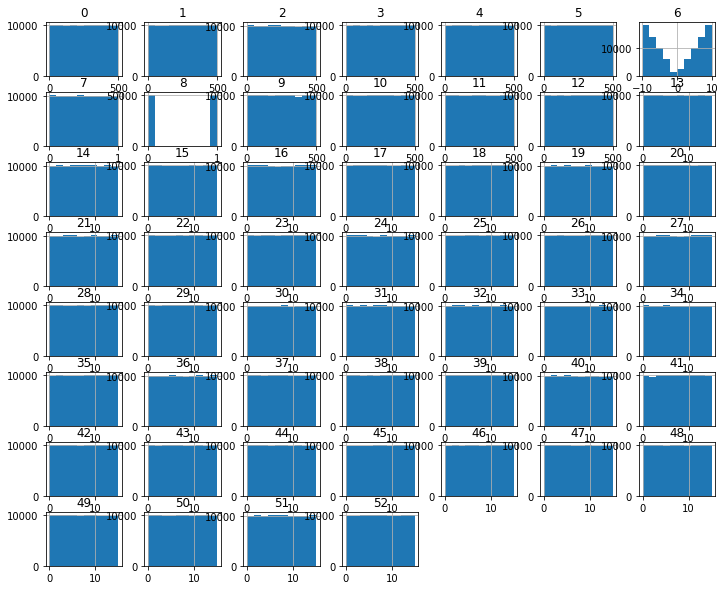

In [8]:
combined = combined[num_cols + cat_cols]
combined.hist(figsize=(12, 10))

In [9]:
train_data = train_data[num_cols + cat_cols]
train_data['target'] = target


## Correlation matrix ##

For greater clarity built correlation matrix using pandas method corr for train and test data.

<AxesSubplot:>

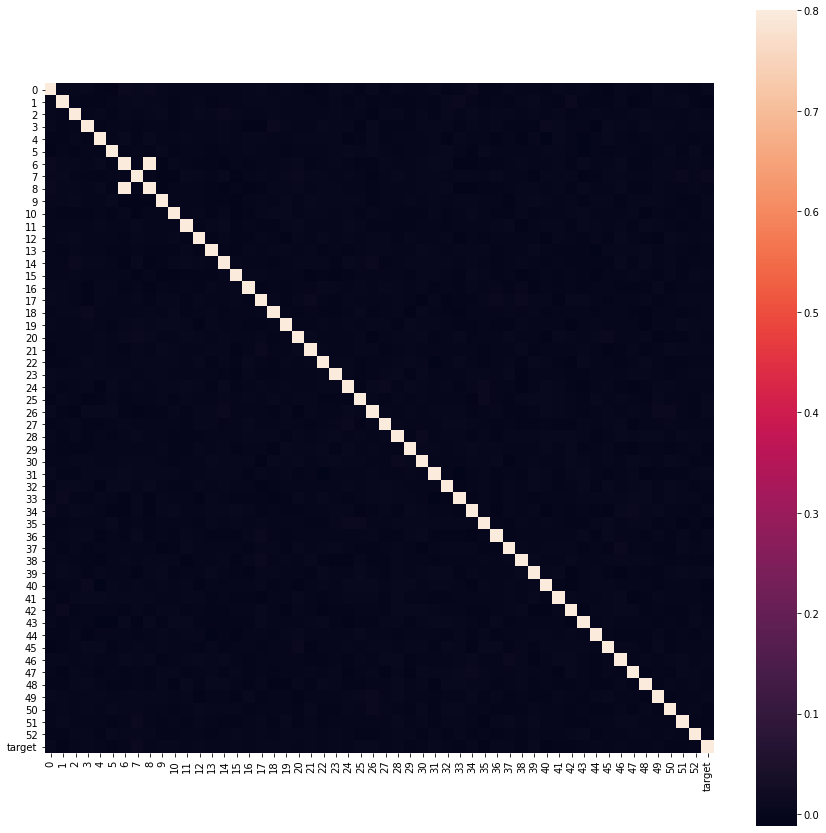

In [10]:
C_mat = train_data.corr()
fig = plt.figure(figsize=(15, 15))
sns.heatmap(C_mat, vmax=0.8, square=True)


<AxesSubplot:>

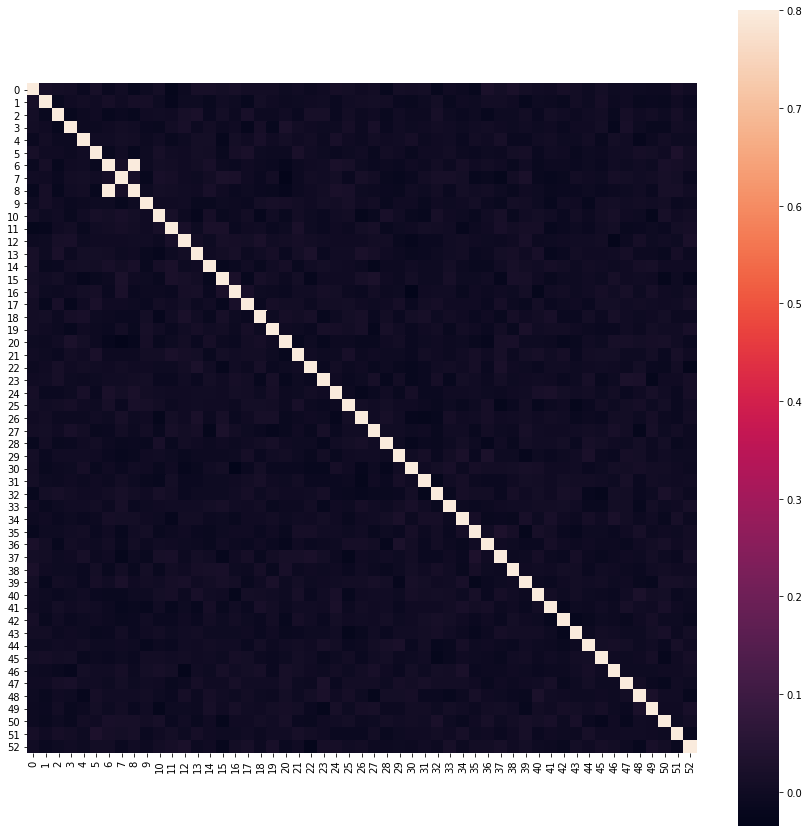

In [11]:
C_mat_test = test_data.corr()
fig = plt.figure(figsize=(15, 15))
sns.heatmap(C_mat_test, vmax=0.8, square=True)

 After data analysis: strong linear dependency between 6 and 8 column. So we can make decision about dropping out
 one of these features, for example 8 column.

In [12]:
def split_combined():
    global combined
    train = combined[:90000]
    test = combined[90000:]

    return train, test

In [13]:
train, test = split_combined()
print('train shape: {}\ntest shape: {}'.format(train.shape, test.shape))

train shape: (90000, 53)
test shape: (10000, 53)


In [14]:
train.head()

,0,1,2,3,4,5,6,7,8,9,...,43,44,45,46,47,48,49,50,51,52
0,236,488,16,221,382,97,-4.472136,0.107472,0,132,...,10.125020,13.340874,0.870542,1.962937,7.466666,11.547794,8.822916,9.046424,7.895535,11.010677
1,386,206,357,232,1,198,7.810250,0.763713,1,143,...,10.584802,12.484882,7.168680,2.885415,12.413973,10.260494,10.091351,9.270888,3.173994,13.921871
2,429,49,481,111,111,146,8.602325,0.651162,1,430,...,10.273114,14.030257,0.394970,8.160625,12.592059,8.937577,2.265191,11.255721,12.794841,12.080951
3,414,350,481,370,208,158,8.306624,0.424645,1,340,...,6.885179,2.789577,6.416708,10.549814,11.456437,6.468099,2.519049,0.258284,9.317696,5.383098
4,318,359,20,218,317,301,8.124038,0.767304,1,212,...,11.162686,1.886560,1.919999,2.268203,0.149421,4.105907,10.416291,6.816217,8.586960,4.512419


In [15]:
test.head()

,0,1,2,3,4,5,6,7,8,9,...,43,44,45,46,47,48,49,50,51,52
90000,259,388,402,340,156,382,3.316625,0.218760,1,164,...,7.163474,10.227235,0.889111,9.190222,4.670908,0.931525,7.634177,0.158196,13.432551,2.511191
90001,441,192,381,421,452,123,-8.888194,0.700228,0,349,...,10.619064,9.339161,4.221861,0.595563,13.865748,0.328453,11.507599,9.107966,1.302407,11.105604
90002,83,129,107,156,247,191,2.645751,0.494556,1,297,...,1.819890,10.670237,10.350867,5.134417,5.898995,8.374986,4.638049,3.160023,2.243799,5.073030
90003,183,438,191,116,491,403,-6.164414,0.511117,0,272,...,4.168135,12.782579,0.513072,0.321295,11.334062,11.735511,1.911520,8.365676,4.877288,11.601819
90004,449,156,310,188,279,465,8.000000,0.756416,1,90,...,7.908122,1.140498,14.165074,7.688796,5.079241,8.152186,1.680403,13.215111,5.823109,1.038015


In [16]:
def make_submission(prediction, sub_name):
    nums = [num for num in range(0, 53)]
    cols = [f'{str(n)}' for n in nums]
    my_submission = pd.DataFrame(columns=cols)
    for i in nums:
        my_submission[f'{str(i)}'] = test[f'{str(i)}']
    my_submission['target'] = prediction
    my_submission.to_csv('{}.csv'.format(sub_name), index=False)
    print('A submission file has been made')

## Build NN Model ##

In [17]:
NN_model = Sequential()

# The Input Layer :
NN_model.add(Dense(128, kernel_initializer='normal', input_dim=train.shape[1], activation='relu'))

# The Hidden Layers :
NN_model.add(Dense(256, kernel_initializer='normal', activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal', activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal', activation='relu'))

# The Output Layer :
NN_model.add(Dense(1, kernel_initializer='normal', activation='linear'))

In [18]:
# Compile the network :
NN_model.compile(loss='mean_squared_error', optimizer='adam', metrics=RootMeanSquaredError())
NN_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               6912      
_________________________________________________________________
dense_1 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_3 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 171,777
Trainable params: 171,777
Non-trainable params: 0
_________________________________________________________________


In [19]:
# checkpoint_name = 'Weights-{epoch:03d}--{val_loss:.5f}.hdf5'
filepath = 'weights_best.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
callbacks_list = [checkpoint]
NN_model.fit(train, target, epochs=50, batch_size=32, validation_split=0.2, callbacks=callbacks_list)

Epoch 1/50
2250/2250 [==============================] - 55s 7ms/step - loss: 904.6605 - root_mean_squared_error: 30.0625 - val_loss: 865.7575 - val_root_mean_squared_error: 29.4238

In [20]:
# Load wights file of the best model :
# wights_file = 'Weights-050--0.05109.hdf5'     # choose the best checkpoint
# NN_model.load_weights(wights_file)    # load it
NN_model.load_weights(filepath)
NN_model.compile(loss='mean_squared_error', optimizer='adam', metrics=RootMeanSquaredError())

In [21]:
predictions = NN_model.predict(test)
make_submission(predictions[:, 0], 'submission_NN')

A submission file has been made


## Drop dependencies and normalize data ##

In [22]:
train_without_8 = train.drop(['8'], axis=1)
train_without_8.head()

,0,1,2,3,4,5,6,7,9,10,...,43,44,45,46,47,48,49,50,51,52
0,236,488,16,221,382,97,-4.472136,0.107472,132,281,...,10.125020,13.340874,0.870542,1.962937,7.466666,11.547794,8.822916,9.046424,7.895535,11.010677
1,386,206,357,232,1,198,7.810250,0.763713,143,109,...,10.584802,12.484882,7.168680,2.885415,12.413973,10.260494,10.091351,9.270888,3.173994,13.921871
2,429,49,481,111,111,146,8.602325,0.651162,430,488,...,10.273114,14.030257,0.394970,8.160625,12.592059,8.937577,2.265191,11.255721,12.794841,12.080951
3,414,350,481,370,208,158,8.306624,0.424645,340,111,...,6.885179,2.789577,6.416708,10.549814,11.456437,6.468099,2.519049,0.258284,9.317696,5.383098
4,318,359,20,218,317,301,8.124038,0.767304,212,141,...,11.162686,1.886560,1.919999,2.268203,0.149421,4.105907,10.416291,6.816217,8.586960,4.512419


In [23]:
train_without_8.shape

(90000, 52)

According to df.describe() our data in different ranges, so we need to normalize data

In [24]:
scaler = StandardScaler()
normalized_train = scaler.fit_transform(train_without_8)

In [25]:
test_without_8 = test.drop(['8'], axis=1)
scaler = StandardScaler()
normalized_test = scaler.fit_transform(test_without_8)

## Build DTR Model ##

In [26]:
X_train, X_val, y_train, y_val = train_test_split(normalized_train, target, test_size=0.2, random_state=1)
DTRModel = DecisionTreeRegressor(max_depth=20, min_samples_leaf=5, min_samples_split=2, random_state=1)
DTRModel.fit(X_train, y_train)

# Get the RMSE on the validation data
DTRpredictions = DTRModel.predict(X_val)
RMSE = np.sqrt(mean_squared_error(y_val, DTRpredictions))
print('DTR validation RMSE = ', RMSE)

DTR validation RMSE =  0.007356722789337169


In [27]:
DTRpredictions = DTRModel.predict(normalized_test)
make_submission(DTRpredictions, 'Submission_DTR')

A submission file has been made


## Build Random Rorest Model ##

In [28]:
X_train, X_val, y_train, y_val = train_test_split(normalized_train, target, test_size=0.2, random_state=1)
RFRModel = RandomForestRegressor(verbose=2, n_estimators=20, random_state=1)
RFRModel.fit(X_train, y_train)

# Get the RMSE on the validation data
RFRpredictions = RFRModel.predict(X_val)
RMSE = np.sqrt(mean_squared_error(y_val, RFRpredictions))
print('Random forest validation RMSE = ', RMSE)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  2.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.2s finished


building tree 1 of 20
building tree 2 of 20
building tree 3 of 20
building tree 4 of 20
building tree 5 of 20
building tree 6 of 20
building tree 7 of 20
building tree 8 of 20
building tree 9 of 20
building tree 10 of 20
building tree 11 of 20
building tree 12 of 20
building tree 13 of 20
building tree 14 of 20
building tree 15 of 20
building tree 16 of 20
building tree 17 of 20
building tree 18 of 20
building tree 19 of 20
building tree 20 of 20
Random forest validation RMSE =  0.004397780733418526


In [29]:
RFRpredictions = RFRModel.predict(normalized_test)
make_submission(RFRpredictions, 'Submission_RF')

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


A submission file has been made


## Build XGBRegressor ##

In [30]:
X_train, X_val, y_train, y_val = train_test_split(normalized_train, target, test_size=0.2, random_state=1)
XGBModel = XGBRegressor(random_state=1)
XGBModel.fit(X_train, y_train, verbose=False)

# Get the RMSE on the validation data
XGBpredictions = XGBModel.predict(X_val)
RMSE = np.sqrt(mean_squared_error(y_val, XGBpredictions))
print('XGBoost validation RMSE = ', RMSE)

XGBoost validation RMSE =  0.04223530416813067


In [31]:
XGBpredictions = XGBModel.predict(normalized_test)
make_submission(XGBpredictions, 'Submission_XGB')

A submission file has been made


# Conclusion #
### Preprocessing ###
    - After data analysis it was decided to leave 52 features for building a model, because 8 and 6 are linear dependent
    features. Further dimensionality reduction is possible with knowledge of the information about the columns.
    - The features have a different scale, therefore it was normalized.
### Model ##
    - There is NN implementation.
    - Also we have Random Forest Regressor with good results. This advanced classical ML algorithm was used because we
    have relatively small database with tabular data.